In [97]:
import numpy as np
import scipy as sp
import scipy.interpolate as spint

import pandas_datareader.data as web
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt 
%matplotlib inline

# VG-процесс

Рассмотрим сначала гамма-процесс. Он имеет меру Леви с плотностью

$$
f_\nu(y) = \beta\frac{e^{-\alpha y}}{y} \mathbb{1}(y>0)
$$

и характеристическую экспоненту

$$
\Psi_X(\xi) = -\beta \ln (1 - i\xi/\alpha).
$$

По построению это всего лишь процесс с независимыми приращениями

$$
X_{t} - X_{s} \sim \Gamma(\alpha, \beta(t-s)).
$$

Траектории такого процесса неубывают, это связано с тем, что приращения почти наверное положительные.





In [98]:
class GammaProcess:
    
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    def sampleTrajs(self, x0, N, ts):
        '''
        Samples N trajectories of the process on range [0,T]
    
        Parameters
        float x0 -- start
        int N -- number of trajectories
        float[] ts -- the observation times
    
        Returns
        xs -- (N,len(ts))
        '''

        xs=np.zeros([N,len(ts)])
        xs[:,0]=x0
        for kk in np.arange(1,len(ts)):
            noises=np.random.gamma(shape=self.alpha,scale=(self.beta*(ts[kk]-ts[kk-1])), size=(N,))
            xs[...,kk]=xs[...,kk-1] + noises
    
        return xs
    

In [99]:
x0=0

alpha=0.15
beta=1
N=10
T=3
Nt=100
ts = np.arange(0,T+T/(2*Nt), T/Nt)

gamProc = GammaProcess(alpha,beta)
trajs = gamProc.sampleTrajs(x0,N,ts)


#print(trajs, times)

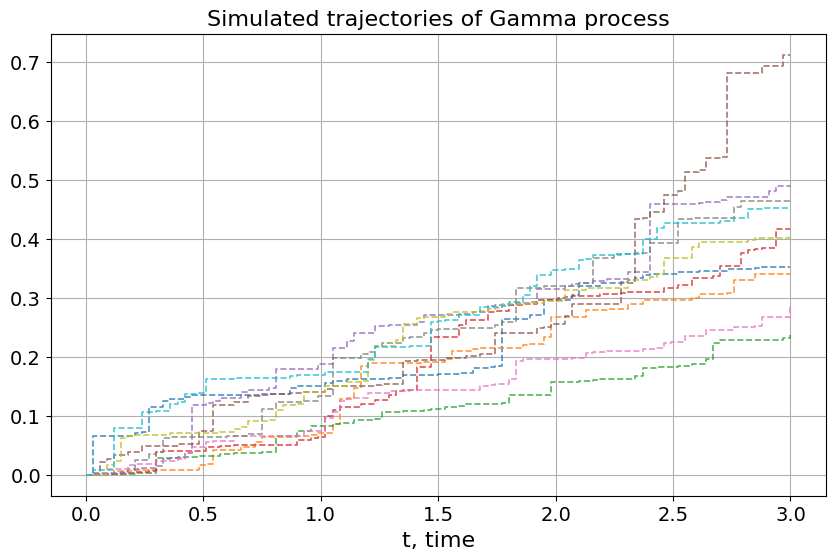

In [100]:
f, ax = plt.subplots(figsize=(10,6))

ax.grid()
ax.set_title('Simulated trajectories of Gamma process',fontsize=16)
ax.set_xlabel('t, time',fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.step(ts,trajs.T,"--",where="post", linewidth=1.2, alpha=0.8)

Сам по себе гамма-процесс не так интересен, потому что это что-то похожее на Пуассоновский процесс. Но мы его используем для того, чтобы построить ещё одну ценовую модель, которую можно использовать для оценки опционов. 

Variance-Gamma -- это простейший процесс Леви с бесконечной интенсивностью прыжков и который двигается только за счёт прыжков: гауссовской компоненты у него нет. Процесс имеет характеристическую экспоненту

$$
\Psi(\xi) = -\beta \ln\left( 1 - i\xi c/\alpha + \beta^2\xi^2/(2\alpha)\right), \quad \alpha,c \in \mathbb{R}, ~ \beta>0
$$

и изначально авторами предлагался в виде

$$
Y_t = \mu X_t + \sigma W_{X_t},
$$

где $X$ -- Это гамма-процесс, а $W$ -- Винеровский процесс.


In [101]:
class WienerDriftProcess:
    
    def __init__(self, gamma=0, sigma=1):
        self.gamma = gamma
        self.sigma = sigma
        
    def sampleTrajs(self,x0,ts,N):
        '''
        Simulates trajectories of Wiener process
        Input
        float x0 -- initial value
        float[] ts -- times
        int N -- number of trajectories to simulate
        Returns
        float[] of shape (Ntraj,xs.shape[0],len(ts))
        '''
        if(len(ts.shape)==1):
            ts = ts.unsqueeze(0)
            print("AAAAAA")
            
        
        xs=np.zeros_like(ts)
        print(ts.shape, xs.shape)
        xs[...,0]=x0
        for kk in np.arange(1,ts.shape[1]):
            noises=np.random.standard_normal(size=(N,))
            xs[...,kk]=xs[...,kk-1] + self.sigma*np.sqrt(ts[:,kk]-ts[:,kk-1])*noises
    
        return xs + self.gamma*ts
    
class VarianceGammaProcess:
    
    def __init__(self, alpha, beta, mu, sigma):
        self.gammaProc = GammaProcess(alpha=alpha,beta=beta)
        self.wienProc = WienerDriftProcess()
        self.mu = mu
        self.sigma = sigma
        
    def sampleTrajs(self, x0, N, ts):
        '''
        Samples N trajectories of the process on range [0,T]
    
        Parameters
        float x0 -- start
        int N -- number of trajectories
        float[] ts -- the observation times
    
        Returns
        xs -- (N,len(ts))
        '''
        gammaProc = self.gammaProc.sampleTrajs(0,N,ts)
        xs = x0+ self.mu*gammaProc + self.sigma * self.wienProc.sampleTrajs(0,gammaProc,N)
        print(xs[:,0])
        return xs
        
    

In [102]:
x0=0

alpha=0.15
beta=0.2
mu=0.1
sigma=0.2

N=10
T=3
Nt=10
ts = np.arange(0,T+T/(2*Nt), T/Nt)

gamProc = VarianceGammaProcess(alpha,beta, mu, sigma)
trajs = gamProc.sampleTrajs(x0,N,ts)


#print(trajs, times)

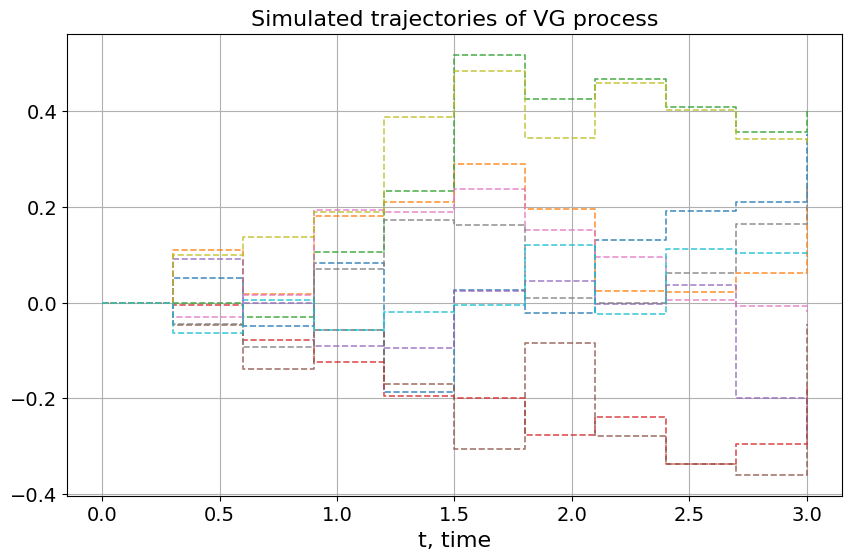

In [103]:
f, ax = plt.subplots(figsize=(10,6))

ax.grid()
ax.set_title('Simulated trajectories of VG process',fontsize=16)
ax.set_xlabel('t, time',fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.step(ts,trajs.T,"--",where="post", linewidth=1.2, alpha=0.8)